### Imports:

In [23]:
import numpy as np
import pandas as pd
import SimpleITK as sitk
import csv
import os
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D


### Reading Data:

In [33]:
def load_itk_image(filename):
    itkimage = sitk.ReadImage(filename)

    numpyImage = sitk.GetArrayFromImage(itkimage)
    numpyOrigin = np.array(list(reversed(itkimage.GetOrigin())))
    numpySpacing = np.array(list(reversed(itkimage.GetSpacing())))

    return numpyImage, numpyOrigin, numpySpacing

def read_luna_dataset(data_path):
    Dataset={}
    subsets = [d for d in os.listdir(data_path) if os.path.isdir(os.path.join(data_path, d))]

    for subset in subsets:
        mhd_files = [f for f in os.listdir(os.path.join(data_path, subset)) if f.endswith(".mhd")]
        Dataset[subset] = {"mhd_files": mhd_files}

        if subset == "subset0":
            for mhd_file in Dataset[subset]["mhd_files"]:
                numpyImage, numpyOrigin, numpySpacing = load_itk_image(os.path.join(data_path, subset, mhd_file))
                Dataset[subset]["loaded_mhd"] = [numpyImage, numpyOrigin, numpySpacing]

    return Dataset


In [ ]:
if __name__ == "__main__":
    read_luna_dataset("Data")

In [4]:
def load_csv(filename):
    return pd.read_csv(f"Data/{filename}")

In [21]:
def basic_statistics(data):
    print("Infos:\n", data.info())
    print("Description:\n", data.describe())
    print("Presence of null values:\n")
    print(data.isnull().sum())

In [22]:
if __name__ == "__main__":
    annotations = load_csv("annotations.csv")
    basic_statistics(annotations)
    

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1186 entries, 0 to 1185
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   seriesuid    1186 non-null   object 
 1   coordX       1186 non-null   float64
 2   coordY       1186 non-null   float64
 3   coordZ       1186 non-null   float64
 4   diameter_mm  1186 non-null   float64
dtypes: float64(4), object(1)
memory usage: 46.5+ KB
Infos:
 None
Description:
             coordX       coordY       coordZ  diameter_mm
count  1186.000000  1186.000000  1186.000000  1186.000000
mean     -5.067547     8.428113  -160.159029     8.306527
std      84.468115    98.316003   279.829437     4.762033
min    -164.351031  -283.834336  -790.074799     3.253443
25%     -80.909225   -51.549643  -221.197808     5.107177
50%     -32.855132    18.787926  -167.615160     6.433600
75%      76.830069    67.245915  -109.735281     9.696301
max     164.763985   271.405521  1790.494057    32.27003

In [24]:
def scatter(data):
    # Create a 3D scatter plot
    fig = plt.figure(figsize=(10, 7))
    ax = fig.add_subplot(111, projection='3d')

    # Scatter plot
    ax.scatter(data["coordX"], data["coordY"], data["coordZ"], c='blue', alpha=0.5)

    # Labels
    ax.set_xlabel("X Coordinate")
    ax.set_ylabel("Y Coordinate")
    ax.set_zlabel("Z Coordinate")
    ax.set_title("3D Scatter Plot of Coordinates")

    plt.show()

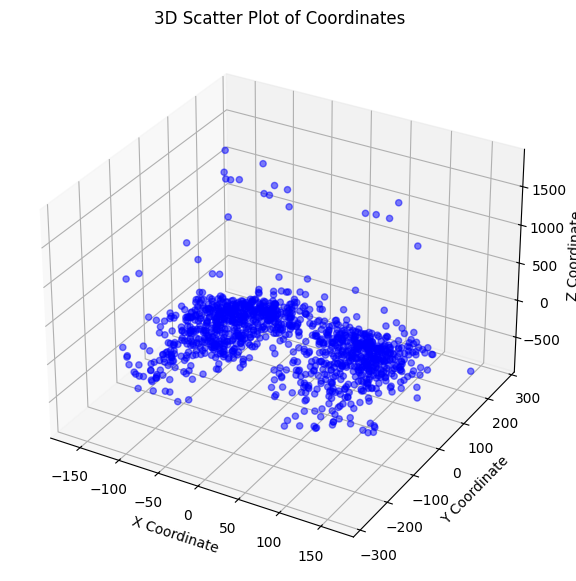

In [26]:
if __name__ == "__main__":
    scatter(annotations)

In [27]:
def diameters_hist(data):
    plt.figure(figsize=(8, 5))
    plt.hist(data["diameter_mm"], bins=30, color="skyblue", edgecolor="black")
    plt.xlabel("Diameter (mm)")
    plt.ylabel("Frequency")
    plt.title("Distribution of Nodule Diameters")
    plt.show()


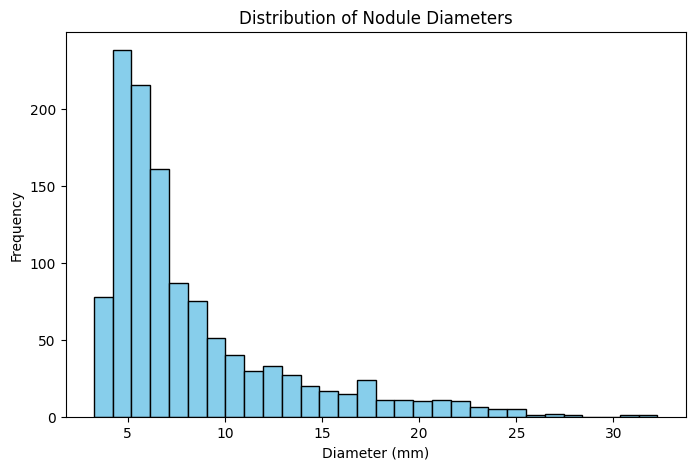

In [28]:
if __name__ == "__main__":
    diameters_hist(annotations)

In [32]:
def visualize_single_slice(ct_scan):
    numpyImage = ct_scan["subste0"][0]
    # Pick the middle slice along the Z-axis
    slice_idx = numpyImage.shape[0] // 2  
    slice_2D = numpyImage[slice_idx]  # Extract the middle slice

    # Display the slice
    plt.figure(figsize=(8, 8))
    plt.imshow(slice_2D, cmap="gray")  # Use 'gray' colormap for CT images
    plt.title(f"CT Scan Slice {slice_idx}")
    plt.axis("off")  # Hide axis for better visualization
    plt.show()

In [ ]:
if __name__ == "__main__":
    visualize_single_slice(data)